### Importing libraries

In [1]:
# Importing xarray to unpack the netCDF file
import xarray as xr

# Importing pyplot to plot the information
import matplotlib.pyplot as plt

# Importing cartopy.crs to work with projections
import cartopy.crs as ccrs

# Importing cartopy.feature to add features to the map
import cartopy.feature as cfeature

#Importing numpy for manipulation arrays
import numpy as np

#Importing panda
import pandas as pd
import os

#Importing netcdf4 library
from netCDF4 import Dataset, date2num

### Functions

In [2]:
# Creating the function to calculate the RMSE
def rmse(forecast, obs):
    return np.sqrt(np.nanmean(((np.array(forecast) - np.array(obs)) ** 2), axis=0))

# Creating a xarray and the function to save the RMSE in netcdf
def write_netcdf (mat, xarray_ref, name, unit, ref_date, output, date):
    
    # Removing the outpot file - if any
    try : 
        os.remove(output)
    except :
        print('Creating file', output)
    nc = Dataset(output, 'w', format='NETCDF4')
    t, nlat, nlon = mat.shape
    
    # Creating dimension of lat, lon and time
    lat = nc.createDimension('lat', nlat)
    lon = nc.createDimension('lon', nlon)
    time = nc.createDimension('time', t)
    
    # Creating variabes lat, lon and time
    latitudes = nc.createVariable('lat','f4',('lat',))
    longitudes = nc.createVariable('lon','f4',('lon',))
    times = nc.createVariable('time','f8',('time',))
   
    latitudes.units = 'degrees north'
    longitudes.units = 'degrees east'
    var = nc.createVariable(name,'f8',('time','lat','lon',))

    var.units = unit
    times.units = f'hours since {ref_date} 00:00:00.0'
    
    # Assigning calendar
    times.calendar = 'standard'
     
    latitudes[:] = xarray_ref.lat
    longitudes[:] = xarray_ref.lon
    times[:] = date2num(date, units=times.units, calendar=times.calendar)
    var[:] = mat
   
    nc.close()
    
# Creating the function to save 2D maps for all times    
def plot2d(mat, lats, lons, date):

    # Creating a picture object to receive the map
    fig = plt.figure(figsize=(10, 8))

    # Creating axis with a projection
    ax = fig.add_subplot(111, projection=ccrs.PlateCarree())

    # Creating longitude and latitude matrices
    lon, lat = np.meshgrid(lons, lats)

    # Plotting the RMSE for the domain
    im = ax.contourf(lon, lat, mat, levels=np.arange(0,5.5,0.5),
                     cmap='BuPu', 
                     transform=ccrs.PlateCarree())
    
    # Inserting a colorbar
    cbar = plt.colorbar(im, ax=ax, pad=0.08, fraction=0.04, orientation='horizontal')
    cbar.set_label(label='RSME (degC/6h)', size=14)
    cbar.ax.tick_params(labelsize=12)

    # Contour of continents
    ax.add_feature(cfeature.COASTLINE)

    # Country boundaries
    ax.add_feature(cfeature.BORDERS)

    # State limits
    states = cfeature.NaturalEarthFeature(category='cultural',
                                      name='admin_1_states_provinces_shp',
                                      scale='50m',
                                      facecolor='none')
    ax.add_feature(states, edgecolor='k', linestyle='--')

    # Figure title
    ax.set_title(f'RMSE Temperature (degC/6h) {date}', fontsize=20, y=1.06)
    plt.xlabel('Longitude', fontsize=18)
    plt.ylabel('Latitude', fontsize=18) 

    # Gridlines
    gl = ax.gridlines(crs=ccrs.PlateCarree(), linestyle='--', color='gray', draw_labels=True)

    # Removing labels
    gl.xlabels_top = False
    gl.ylabels_right = False

    gl.xlabel_style = {'size': 12, 'color': 'black', 'weight': 'normal'}
    gl.ylabel_style = {'size': 12,'color': 'black', 'weight': 'normal', 'rotation': 0}

    # Saving figure
    plt.savefig(f'C:\\Users\\bruna\\ClimaTempo\\output\\rmse_2D\\rmse_{date.strftime("%Y%m%d%H")}.tiff',
                dpi=300,bbox_inches='tight',facecolor='w')

### reading netcdf files (forecast and observations)

In [3]:
# reading the netCDF forecast.nc
forc = xr.open_dataset('C:\\Users\\bruna\\ClimaTempo\\input\\files\\forecast.nc')

# reading the netCDF observation.nc
obs = xr.open_dataset('C:\\Users\\bruna\\ClimaTempo\\input\\files\\observation.nc')

### Changing the name of the variables and converting to the same unit

In [4]:
# variable t2m (from K to degC - from t2m to t_forc) 
t_forc = forc['t2m'] - 273.15

# variable temperatura ( from temperature to t_obs) 
t_obs = obs['temperatura']

### Calculating the RMSE at intervals of 6 hours

In [5]:
# Calling the rmse_list function for looping
rmse_list = list()

for t in range(0, 72, 6):

    rmse_list.append(rmse(t_forc[t:t+6,:,:], t_obs[t:t+6,:,:]))

C:\Users\adrenalina\anaconda3\envs\my-env\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until


### Saving the RMSE to a netcdf

In [6]:
# Writing the RMSE every 6 hours
write_netcdf(np.array(rmse_list), t_forc.resample(time='6H').mean(), 
             'rmse_temp', 'degC/6h', '2018-04-14', 'temp_rmse_06h.nc',
            pd.date_range('2018-04-14', periods=12, freq= '6H').to_pydatetime())

C:\Users\adrenalina\anaconda3\envs\my-env\lib\site-packages\ipykernel_launcher.py:38: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.


### Extracting the RMSE from a lat and lon point (São paulo) and plotting the time series

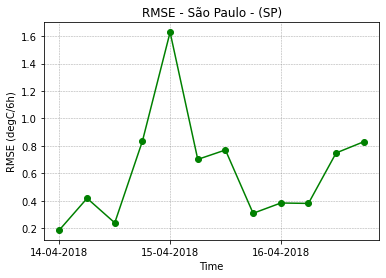

In [7]:
# Assigning list
sp_list= list()

#Calling the rmse_list function in the loop
for data in rmse_list:
    sp_list.append(data[8,26])
    

# Axis x (time)
dates = pd.date_range('2018-04-14', periods=12, freq= '6H').to_pydatetime()
xrange = [dt.strftime('%d-%m-%Y') for dt in dates]

# Chart attributes
plt.plot(sp_list, 'g')
plt.plot( sp_list, 'go')
plt.xticks(ticks = range(0,len(xrange),4), labels = xrange[::4], rotation ='horizontal')
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
plt.ylabel('RMSE (degC/6h)')
plt.xlabel('Time')
plt.title('RMSE - São Paulo - (SP)')
plt.style.context('seaborn-whitegrid')


# Saving in tiff format
plt.savefig('C:\\Users\\bruna\\ClimaTempo\\output\\rmse_ST\\RMSE_temperature.tiff')


### Plotting maps (2D: lat x lon) of the RMSE for timestep

C:\Users\adrenalina\anaconda3\envs\my-env\lib\site-packages\cartopy\mpl\geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  inframe=inframe)


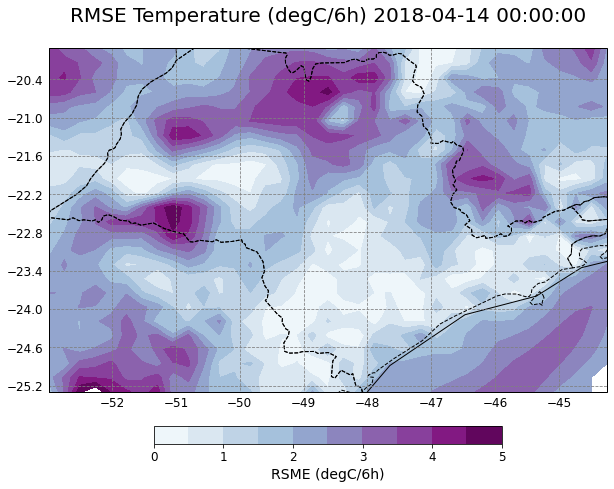

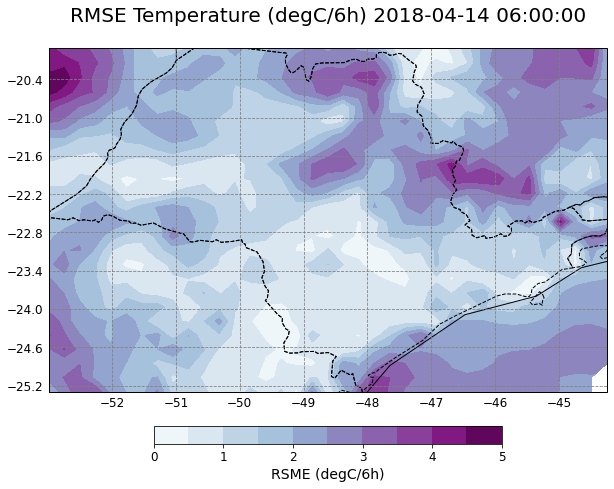

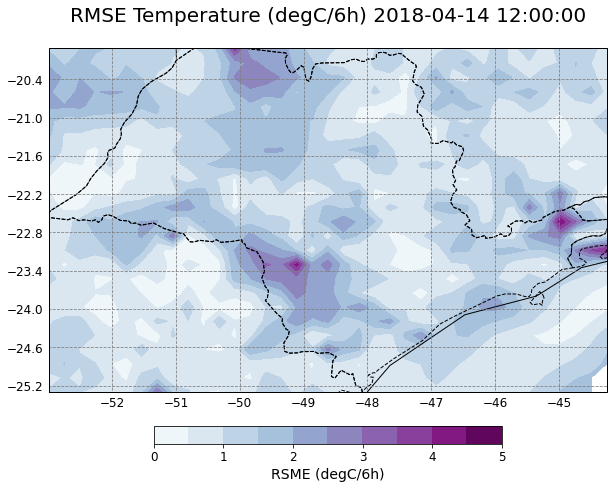

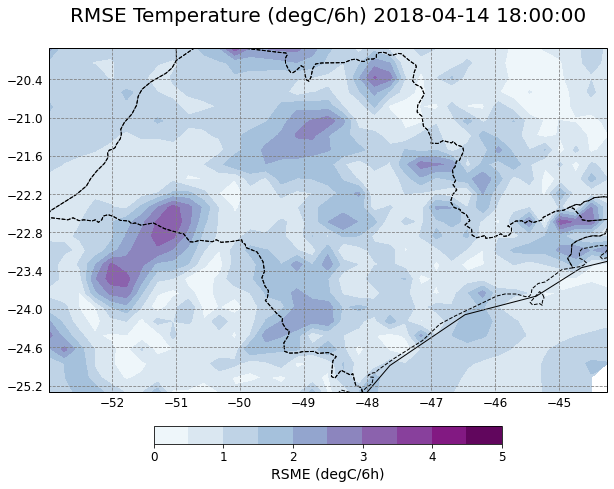

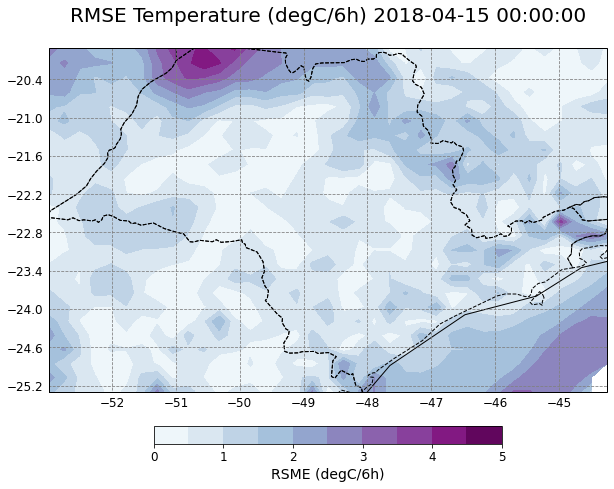

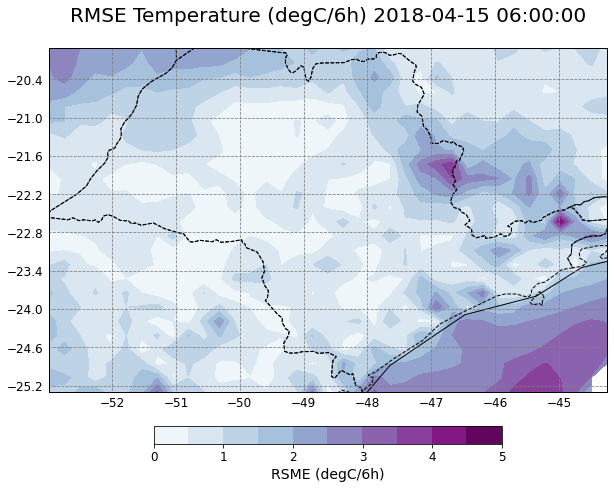

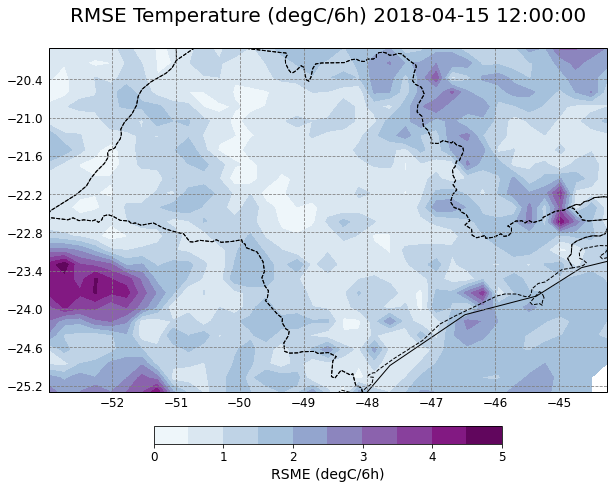

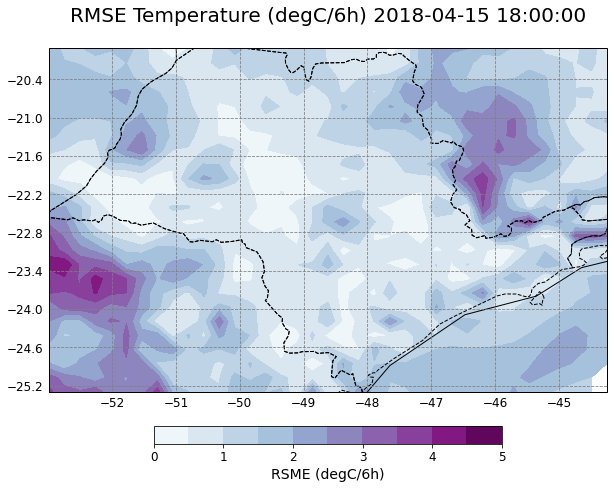

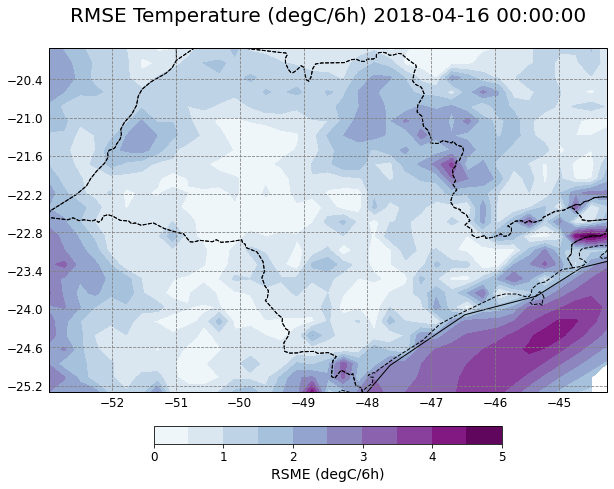

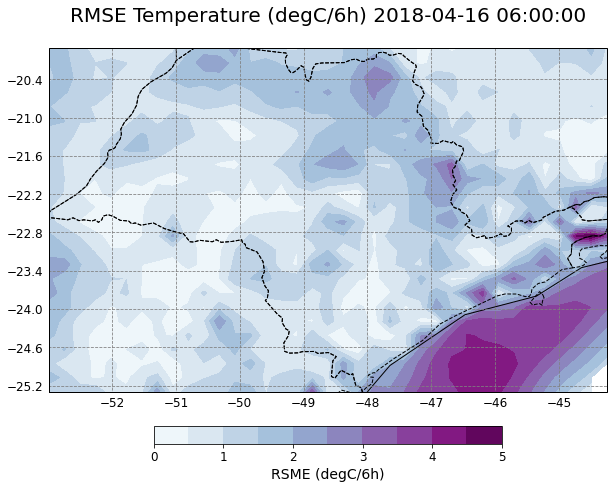

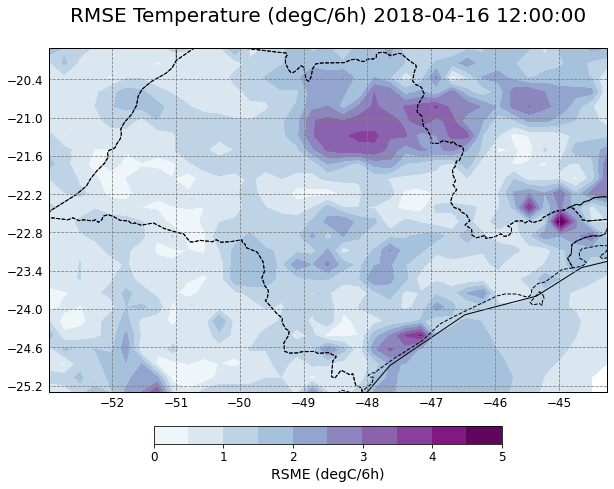

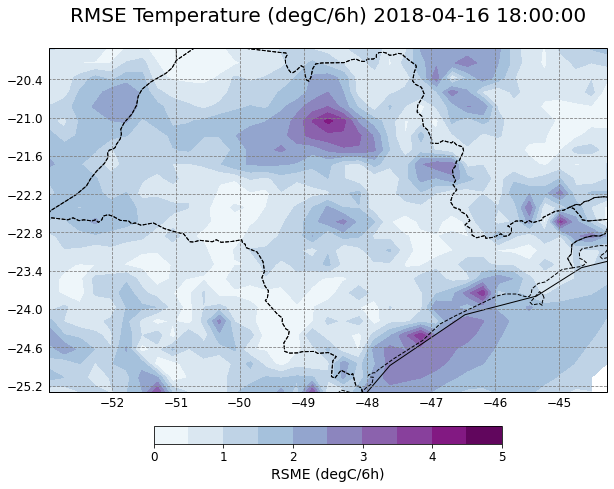

In [8]:
# Calling the plot2d function in the loop
for arr, dt in zip(rmse_list, pd.date_range("2018-04-14", periods=12, freq= "6H").to_pydatetime()):
        
        plot2d(arr, t_forc.lat, t_forc.lon, dt)

### End!